In [94]:
import os, pickle, warnings, itertools
from pathlib import Path
from functools import partial 

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)


%load_ext autoreload
%autoreload 1
%aimport salford_datasets.salford, salford_datasets.salford_raw, transformer_experiment.utils.embeddings, transformer_experiment.utils.finetuning, transformer_experiment.utils.shallow_classifiers, transformer_experiment.utils.plots
%aimport acd_experiment.base_dataset, acd_experiment.salford_adapter, acd_experiment.models, acd_experiment.sci, acd_experiment.systematic_comparison

from salford_datasets.salford import SalfordData, SalfordFeatures, SalfordPrettyPrint, SalfordCombinations
from acd_experiment.salford_adapter import SalfordAdapter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
class Notebook:
    DATA_DIR = Path('data/Salford')
    CACHE_DIR = Path('data/cache')
    IMAGE_DIR = Path('images/shallow')
    SYSTEMATIC_COMPARISON_DIR = Path('data/systematic_comparison/')
    RE_DERIVE = False

In [4]:
from transformer_experiment.utils.shallow_classifiers import load_salford_dataset, get_train_test_indexes

SAL = load_salford_dataset(Notebook.RE_DERIVE, Notebook.DATA_DIR)
SAL_TRAIN_IDX, SAL_TEST_IDX, SAL_TEST_UNSEEN_IDX, SAL_TEST_IS_UNSEEN = get_train_test_indexes(SAL)

2023-04-08 09:29:29,242 [INFO] Loading processed dataset


In [5]:
from acd_experiment.models import Estimator_L1Regression, Estimator_LinearSVM, Estimator_LightGBM, Estimator_L2Regression, Estimator_ElasticNetRegression, Estimator_XGBoost

FEATURE_GROUP_CORRESPONDENCE = {
    'news': 'news',
    'with_phenotype': 'news_with_phenotype',
    'with_composites': 'with_labs',
    'with_labs': 'with_notes_and_labs',
    'with_services': 'with_notes_labs_and_hospital'
}

PRETTY_PRINT_FEATURE_GROUPS = {
    'Reference': 'Reference',
    'news': 'Vitals',
    'with_phenotype': '& Obs',
    'with_composites': '& Scores',
    'with_labs': '& Labs',
    'with_services': '& Services',
}

PRETTY_PRINT_FEATURE_NAMES = {
    k:(
        v.replace('First Blood ', '')
        .replace('First Obs ', '')
        .replace('Emergency Department', 'ED')
    )
    for k,v in SalfordPrettyPrint.items()
}

ESTIMATORS = {_._name: _ for _ in [
    Estimator_LightGBM,
    Estimator_XGBoost,
    Estimator_LinearSVM,
    Estimator_L1Regression,
    Estimator_L2Regression,
    Estimator_ElasticNetRegression,
]}

STUDY_GRID = list(itertools.product(ESTIMATORS.keys(), FEATURE_GROUP_CORRESPONDENCE.keys()))

In [6]:
from acd_experiment.salford_adapter import SalfordAdapter
from sklearn.calibration import CalibratedClassifierCV
import optuna
from acd_experiment.systematic_comparison import get_xy, PipelineFactory

def run_pretuned(sal, estimator_name, feature_group_name, cv_jobs=4, explain_models=['LightGBM']):
    params = optuna.load_study(
        study_name =f'{estimator_name}_None_Within-1_{FEATURE_GROUP_CORRESPONDENCE[feature_group_name]}', storage=f'sqlite:///{Notebook.SYSTEMATIC_COMPARISON_DIR}/{estimator_name}.db'
    ).best_params
    
    estimator = ESTIMATORS[estimator_name]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X, y = SalfordAdapter(sal).xy(
            x=SalfordCombinations[feature_group_name],
            imputation = estimator._requirements['imputation'],
            fillna = estimator._requirements['fillna'],
            ordinal_encoding = estimator._requirements['ordinal'],
            onehot_encoding = estimator._requirements['onehot']
        )
    X_train, y_train = SalfordAdapter(X.loc[SAL_TRAIN_IDX]), y.loc[SAL_TRAIN_IDX].values

    pipeline_factory = PipelineFactory(
        estimator=estimator, resampler=None, X_train=X_train, y_train=y_train,
    )

    model = CalibratedClassifierCV(
        pipeline_factory(**params), cv=cv_jobs, method="isotonic", n_jobs=cv_jobs,
    ).fit(X_train, y_train)


    y_pred_proba = model.predict_proba(X.loc[SAL_TEST_IDX])[:,1]
    y_pred_proba_unseen = y_pred_proba[SAL_TEST_IS_UNSEEN]

    explanations = None
    if estimator_name in explain_models:
        explanations = estimator.explain_calibrated(
            model, X_train, SalfordAdapter(X.loc[SAL_TEST_IDX]), cv_jobs=cv_jobs
        )
        explanations.feature_names = list(map(PRETTY_PRINT_FEATURE_NAMES.get, X.columns))


    return y_pred_proba, y_pred_proba_unseen, explanations

if Notebook.RE_DERIVE or True:
    RESULTS = {}
    for estimator_name, feature_group_name in (pbar := tqdm(STUDY_GRID)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}')
        RESULTS[(estimator_name, feature_group_name)] = run_pretuned(SAL, estimator_name, feature_group_name)

        with open(Notebook.CACHE_DIR/'shallow_results_3.bin', 'wb') as file:
            pickle.dump(RESULTS, file)
else:
    with open(Notebook.CACHE_DIR/'shallow_results_3.bin', 'rb') as file:
            RESULTS = pickle.load(file)

Training ElasticNetRegression on with_services: 100%|██████████| 30/30 [1:45:18<00:00, 210.62s/it]  


In [7]:
from transformer_experiment.utils.shallow_classifiers import get_discriminative_metrics
Y_TRUES = {
    'Complete': SAL.CriticalEvent.loc[SAL_TEST_IDX],
    'Unseen': SAL.CriticalEvent.loc[SAL_TEST_UNSEEN_IDX],
}
def get_full_metrics_tables(results):
    metrics = {
        'Complete': [],
        'Unseen': [],
    }
    for (estimator_name, feature_group_name), y_preds in results.items():
        for y_pred_proba, (y_true_name, y_true) in zip(y_preds, Y_TRUES.items()):

            metrics[y_true_name].append(dict(
                Estimator = estimator_name,
                Features = feature_group_name,
            ) | get_discriminative_metrics(
                y_true, y_pred_proba
            ))
    
    for y_true_name, y_true in Y_TRUES.items():
        metrics[y_true_name].append(dict(
            Estimator='NEWS2',
            Features='Reference'
        ) | get_discriminative_metrics(
            y_true, SAL.NEWS_Score_Admission.loc[y_true.index]
        ))

    return {
        y_true_name: pd.DataFrame(metric_list) for y_true_name, metric_list in metrics.items()
    }

METRICS = get_full_metrics_tables(RESULTS)

## Metrics

### Summary Table

In [8]:
def summary_metrics_select_estimators(metrics, estimators=['LightGBM', 'L2Regression']):
    df = pd.DataFrame(dict(
            Metric=metric,
            Estimator=_['Estimator'],
            Features=PRETTY_PRINT_FEATURE_GROUPS[_['Features']],
            Value=f"{_[metric]:.3f}",
            Dataset=dataset
        ) for dataset, df in metrics.items() for _ in df[df.Estimator.isin(estimators)].to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Features']).unstack()['Value'][list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]]
    return df

summary_metrics_select_estimators(METRICS)

Features                     Vitals  & Obs & Scores & Labs & Services
Metric Estimator    Dataset                                          
AP     L2Regression Complete  0.127  0.205    0.226  0.266      0.748
                    Unseen    0.159  0.258    0.280  0.316      0.806
       LightGBM     Complete  0.231  0.329    0.373  0.437      0.781
                    Unseen    0.289  0.390    0.439  0.512      0.835
AUROC  L2Regression Complete  0.699  0.775    0.805  0.828      0.939
                    Unseen    0.699  0.767    0.809  0.833      0.949
       LightGBM     Complete  0.787  0.834    0.870  0.899      0.957
                    Unseen    0.794  0.837    0.879  0.907      0.964

### Detailed Tables

In [10]:
def detailed_metrics_all_estimators(metrics):
    df = pd.DataFrame(dict(
            Dataset=dataset,
            Metric=metric,
            Estimator=_['Estimator'],
            Features=PRETTY_PRINT_FEATURE_GROUPS[_['Features']],
            Summary = f'{_[metric]:.4f} ({_[metric+"_Lower"]:.4f}-{_[metric + "_Upper"]:.4f})'
        ) for dataset, df in metrics.items() for _ in df.to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).pivot(index=['Features', 'Estimator'], columns=['Metric', 'Dataset'], values='Summary')

    return df.loc[PRETTY_PRINT_FEATURE_GROUPS.values()][['AUROC', 'AP']]

detailed_metrics_all_estimators(METRICS)

Metric                                            AUROC  \
Dataset                                        Complete   
Features   Estimator                                      
Reference  NEWS2                 0.7340 (0.7214-0.7471)   
Vitals     ElasticNetRegression  0.6992 (0.6844-0.7100)   
           L1Regression          0.6981 (0.6834-0.7089)   
           L2Regression          0.6995 (0.6846-0.7101)   
           LightGBM              0.7870 (0.7752-0.8019)   
           LinearSVM             0.7241 (0.7100-0.7403)   
           XGBoost               0.7882 (0.7765-0.8030)   
& Obs      ElasticNetRegression  0.7747 (0.7617-0.7814)   
           L1Regression          0.7752 (0.7624-0.7819)   
           L2Regression          0.7748 (0.7618-0.7817)   
           LightGBM              0.8340 (0.8227-0.8459)   
           LinearSVM             0.7664 (0.7517-0.7747)   
           XGBoost               0.8371 (0.8267-0.8467)   
& Scores   ElasticNetRegression  0.8057 (0.7945-0.8128)   
           L1Regression          0.8070 (0.7960-0.8142)   
           L2Regression          0.8053 (0.7942-0.8122)   
           LightGBM              0.8703 (0.8616-0.8756)   
           LinearSVM             0.8030 (0.7917-0.8104)   
           XGBoost               0.8669 (0.8587-0.8729)   
& Labs     ElasticNetRegression  0.8351 (0.8254-0.8429)   
           L1Regression          0.8279 (0.8181-0.8352)   
           L2Regression          0.8277 (0.8177-0.8350)   
           LightGBM              0.8993 (0.8921-0.9054)   
           LinearSVM             0.8320 (0.8218-0.8396)   
           XGBoost               0.8993 (0.8924-0.9056)   
& Services ElasticNetRegression  0.9395 (0.9318-0.9462)   
           L1Regression          0.9394 (0.9316-0.9461)   
           L2Regression          0.9393 (0.9317-0.9460)   
           LightGBM              0.9572 (0.9525-0.9630)   
           LinearSVM             0.9359 (0.9289-0.9417)   
           XGBoost               0.9568 (0.9524-0.9619)   

Metric                                                   \
Dataset                                          Unseen   
Features   Estimator                                      
Reference  NEWS2                 0.7372 (0.7194-0.7499)   
Vitals     ElasticNetRegression  0.6979 (0.6818-0.7110)   
           L1Regression          0.6972 (0.6815-0.7102)   
           L2Regression          0.6986 (0.6824-0.7116)   
           LightGBM              0.7943 (0.7807-0.8071)   
           LinearSVM             0.7250 (0.7076-0.7378)   
           XGBoost               0.7967 (0.7810-0.8080)   
& Obs      ElasticNetRegression  0.7661 (0.7521-0.7771)   
           L1Regression          0.7663 (0.7528-0.7770)   
           L2Regression          0.7669 (0.7526-0.7778)   
           LightGBM              0.8368 (0.8243-0.8474)   
           LinearSVM             0.7634 (0.7508-0.7753)   
           XGBoost               0.8399 (0.8278-0.8506)   
& Scores   ElasticNetRegression  0.8095 (0.7992-0.8188)   
           L1Regression          0.8116 (0.8016-0.8208)   
           L2Regression          0.8089 (0.7985-0.8181)   
           LightGBM              0.8787 (0.8705-0.8870)   
           LinearSVM             0.8076 (0.7955-0.8167)   
           XGBoost               0.8761 (0.8676-0.8845)   
& Labs     ElasticNetRegression  0.8425 (0.8302-0.8512)   
           L1Regression          0.8332 (0.8219-0.8420)   
           L2Regression          0.8331 (0.8217-0.8416)   
           LightGBM              0.9074 (0.8999-0.9159)   
           LinearSVM             0.8379 (0.8249-0.8461)   
           XGBoost               0.9083 (0.9021-0.9159)   
& Services ElasticNetRegression  0.9492 (0.9430-0.9547)   
           L1Regression          0.9491 (0.9429-0.9549)   
           L2Regression          0.9488 (0.9429-0.9545)   
           LightGBM              0.9643 (0.9592-0.9689)   
           LinearSVM             0.9450 (0.9390-0.9502)   
           XGBoost               0.9643 (0.959

### NEWS Comparison

In [ ]:
from transformer_experiment.utils.shallow_classifiers import get_decision_metrics, get_decision_threshold
from sklearn.metrics import recall_score

def news_threshold_comparison(y_preds, estimators=['LightGBM', 'L2Regression'], news_thresholds=[3, 5, 7], confidence_intervals=True):
    y_true = Y_TRUES['Complete']
    news_values = SAL.loc[y_true.index].NEWS_Score_Admission
    news_sensitivities = {
        threshold: recall_score(y_true, news_values >= threshold) 
        for threshold in news_thresholds
    }

    results = [
        dict(
            Estimator="NEWS",
            Features=None,
            Threshold=f'$\geq {news_threshold}$',
        ) | get_decision_metrics(y_true, news_values >= news_threshold, confidence_intervals) 
        for news_threshold in news_sensitivities.keys()
    ]

    for estimator in estimators:
        for feature_group, feature_group_name in PRETTY_PRINT_FEATURE_GROUPS.items():
            if feature_group == 'Reference':
                continue
            y_pred_proba = y_preds[(estimator, feature_group)][0]
            for news_threshold, observed_sensitivity in news_sensitivities.items():
                threshold = get_decision_threshold(y_true, y_pred_proba, target_recall=observed_sensitivity)
                y_pred = np.where(y_pred_proba > threshold, 1, 0)
                results.append(dict(
                    Estimator=estimator,
                    Features=feature_group_name,
                    Threshold=f'$\geq {news_threshold}$',
                ) | get_decision_metrics(y_true, y_pred, confidence_intervals))

    return pd.DataFrame(results).set_index(['Estimator', 'Features'])#[list(r.columns[-1:]) + list(r.columns[:-1])]

news_threshold_comparison(RESULTS)

## Bar Plots

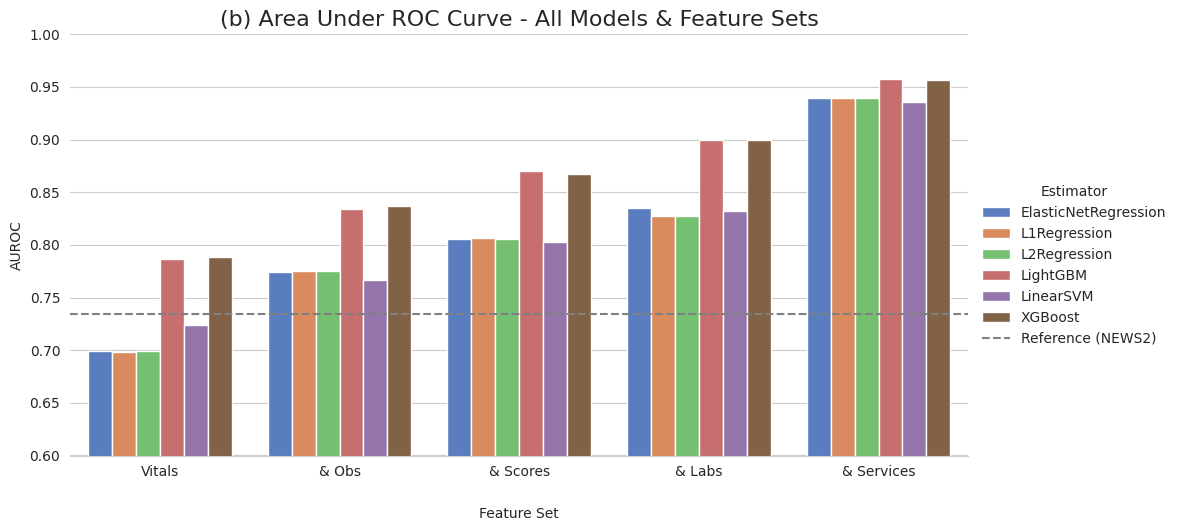

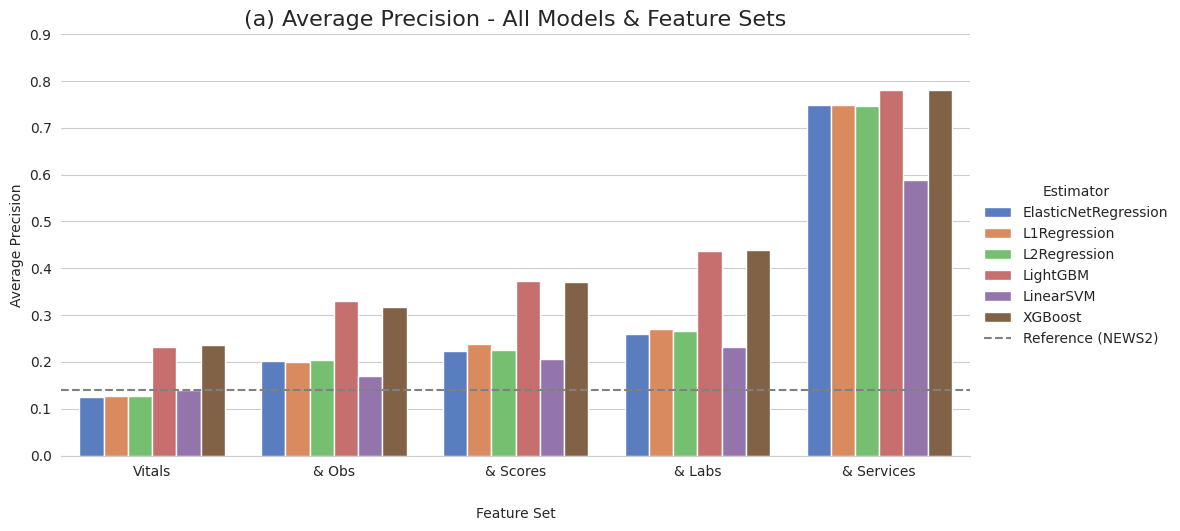

In [28]:
def select_feature_ablation_barplot(metrics_df, metric='AUROC', ylim=(0.0, 1.0), ylabel=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics_df[metrics_df.Estimator != 'NEWS2'].copy()
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(
        df.Features.replace(PRETTY_PRINT_FEATURE_GROUPS), 
        ordered=True, categories=list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]
    )

    g = sns.catplot(
        data=df.sort_values(['Estimator','Features']), x='Features', y=metric, hue='Estimator',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    g.ax.set_ylim(ylim)

    # x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    # y_coords = [p.get_height() for p in g.ax.patches]
    # g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    news_performance = metrics_df.loc[metrics_df.Estimator == 'NEWS2', metric].values[0]

    g.refline(y = news_performance , color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
    g.add_legend(title='Estimator')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    
    if ylabel:
        g.set_ylabels(ylabel)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

select_feature_ablation_barplot(METRICS['Complete'], 'AUROC', (0.6, 1.0), ylabel='AUROC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'auc_bar.svg')
select_feature_ablation_barplot(METRICS['Complete'], 'AP', (0.0, 0.9), ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'ap_bar.svg')

## Calibration Curves

In [ ]:
def estimator_y_preds_across_feature_groups(y_preds, estimator_target='LightGBM'):
    return {
        PRETTY_PRINT_FEATURE_GROUPS[feature_group]: y_pred_proba 
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if estimator == estimator_target
    }

def feature_group_y_preds_across_estimators(y_preds, feature_group_target='with_services'):
    return {
        estimator: y_pred_proba
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if feature_group == feature_group_target
    }

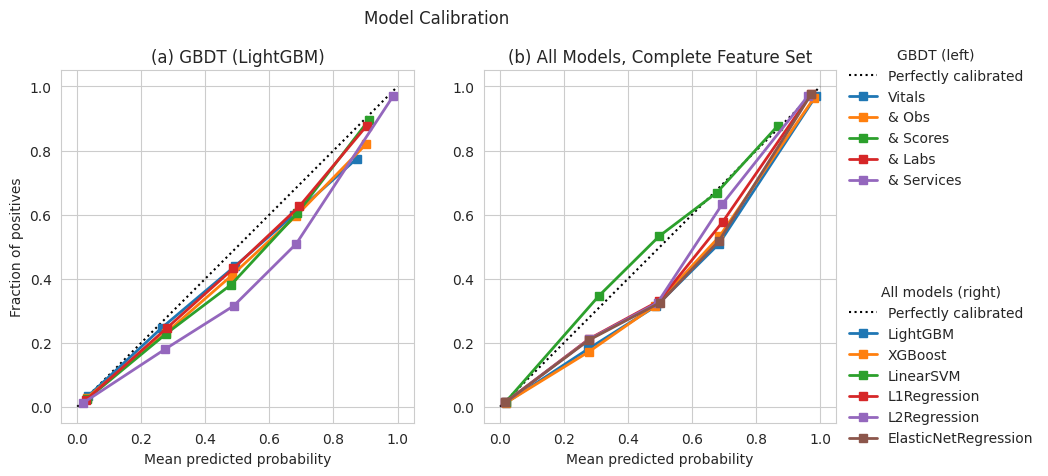

In [53]:
from transformer_experiment.utils.plots import plot_calibration_curves

def calib_curves(y_preds, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_true = Y_TRUES['Complete']
    y_preds_l, y_preds_r = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM'), 
        feature_group_y_preds_across_estimators(y_preds, 'with_services')
    )

    plot_calibration_curves(y_true, y_preds_l, ax=ax[0], title='(a) GBDT (LightGBM)')
    plot_calibration_curves(y_true, y_preds_r, ax=ax[1], title='(b) All Models, Complete Feature Set')

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Model Calibration')
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
   

calib_curves(RESULTS, save=Notebook.IMAGE_DIR/'calib_curves.svg')

## Alert Rate & PR

In [56]:
TEST_SET_N_DAYS = (
    SAL.loc[SAL_TEST_IDX].AdmissionDate.max() - SAL.loc[SAL_TEST_IDX].AdmissionDate.min()
).days
TEST_SET_N_DAYS

1010

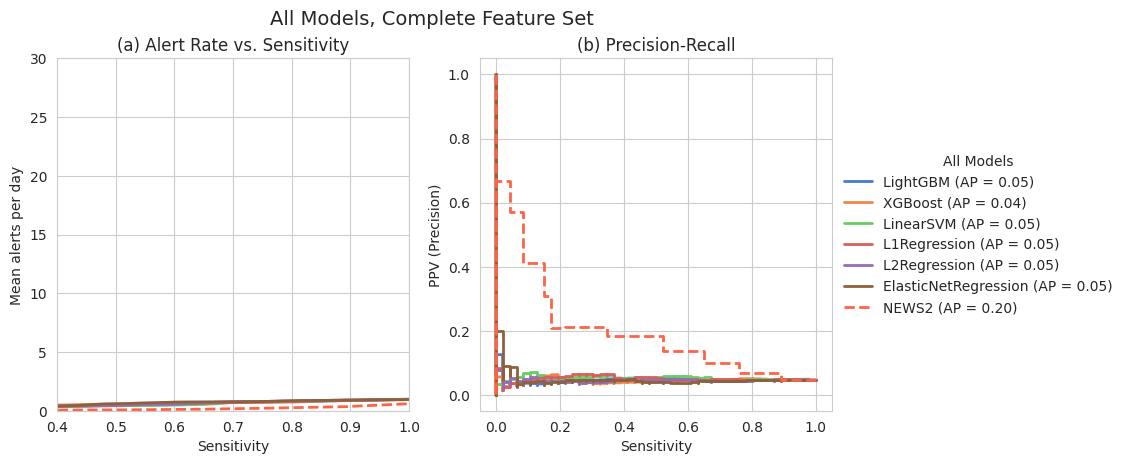

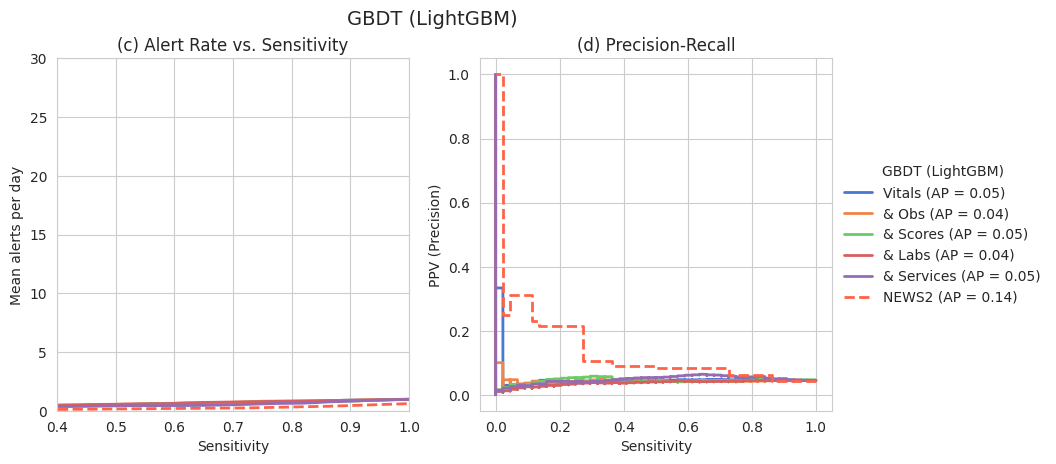

In [74]:
from transformer_experiment.utils.plots import plot_pr_curves, plot_alert_rate

def pr_and_alertrate_curves_estimator(y_preds, estimator, title, legend_label, subtitle_lettering, save=None):
    y_preds = estimator_y_preds_across_feature_groups(y_preds, estimator)   
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves_feature_group(y_preds, feature_group, title, legend_label, subtitle_lettering, save=None):
    y_preds = feature_group_y_preds_across_estimators(y_preds, feature_group)
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}
    
    with sns.color_palette('muted'):
        plot_alert_rate(
            y_true, y_preds | baseline_news, TEST_SET_N_DAYS,
            ax=ax[0], intercepts=False, baseline_key='NEWS2', 
            title=f'{subtitle_lettering[0]} Alert Rate vs. Sensitivity', xlim=(0.4, 1.0), ylim=(0, 30)
        )

        plot_pr_curves(
            y_true, y_preds | baseline_news, 
            smoothing=(not debug), ax=ax[1], 
            palette=sns.color_palette('muted'), 
            baseline_key='NEWS2', 
            title=f'{subtitle_lettering[1]} Precision-Recall'
        )
        
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title=legend_label)
    ax[0].legend([], [], frameon=False)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)

    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

pr_and_alertrate_curves_feature_group(
    RESULTS, 'with_services',
    title='All Models, Complete Feature Set', legend_label='All Models', 
    subtitle_lettering=['(a)', '(b)'],
    save=Notebook.IMAGE_DIR/'alert_pr_all.svg'
)
pr_and_alertrate_curves_estimator(
    RESULTS, 'LightGBM', 
    title='GBDT (LightGBM)', legend_label='GBDT (LightGBM)', 
    subtitle_lettering=['(c)', '(d)'],
    save=Notebook.IMAGE_DIR/'alert_pr_lightgbm.svg'
)

### Intercepts

At sensitivity ~0.841: NEWS Alert rate: 14.574, LGBM Alert rate: 4.035 -> 72.317% less


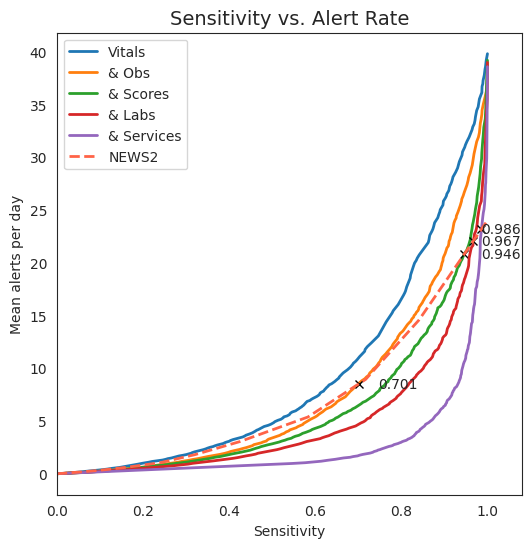

In [79]:
from transformer_experiment.utils.plots import plot_alert_rate, biggest_alert_rate_diff

def plot_alert_rate_with_intercepts(y_preds, estimator='LightGBM'):
    y_preds = estimator_y_preds_across_feature_groups(y_preds, estimator)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}

    plot_alert_rate(
        y_true, y_preds | baseline_news, TEST_SET_N_DAYS,
        intercepts=True, baseline_key='NEWS2', 
    )

    sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
        y_true, baseline_news['NEWS2'], y_preds['& Services'], TEST_SET_N_DAYS,
    )

    print(
        f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
    )


plot_alert_rate_with_intercepts(RESULTS)

## SHAP

### Beeswarm Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


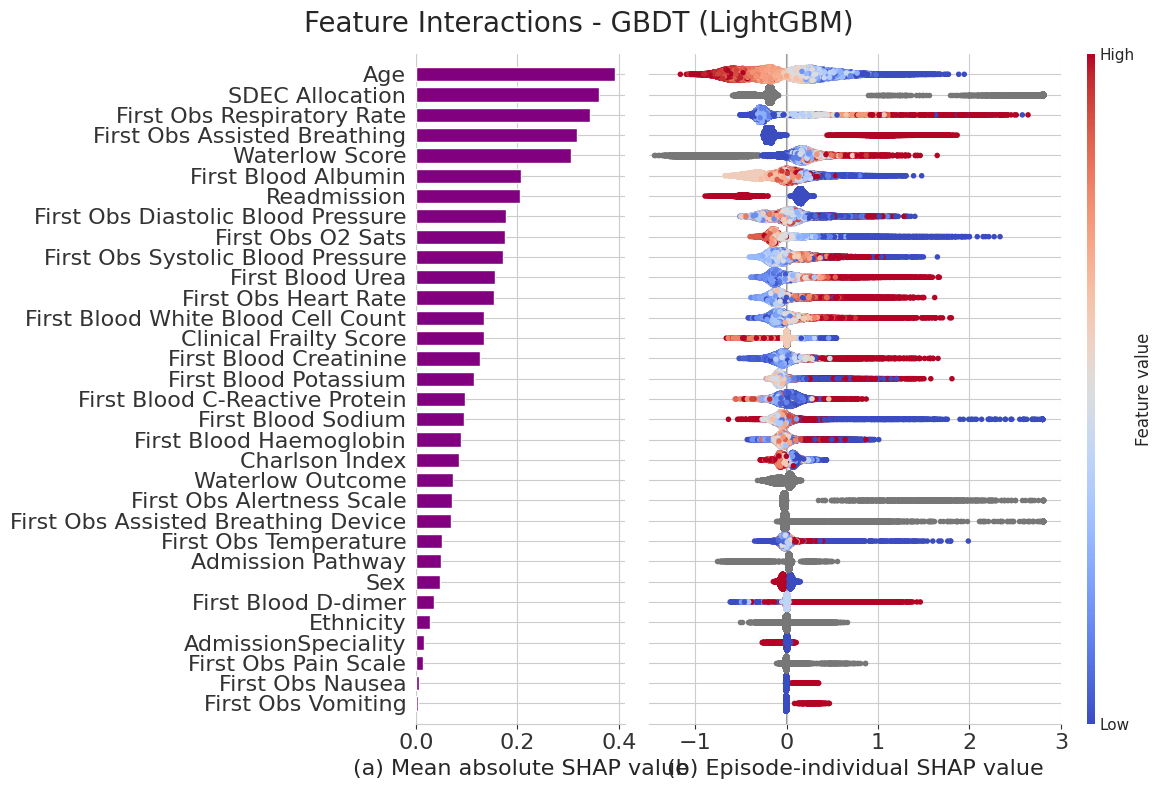

In [120]:
from transformer_experiment.utils.plots import plot_shap_features_joint

def lgbm_shap_beeswarm(y_preds, title='Feature Interactions - GBDT (LightGBM)', save=None):
    explanations = y_preds[('LightGBM', 'with_services')][-1]
    explanations.values[explanations.values >= 3] = 3
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )

lgbm_shap_beeswarm(RESULTS)

### Categorical Features

In [141]:
def categorical_shap_bars_lgbm(y_preds, save=None):
    explanations = y_preds[('LightGBM', 'with_services')][-1]
    
    r = []
    for column in SAL.categorical_columns(SalfordCombinations['with_services']):
        idx = explanations.feature_names.index(column)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(10).index
        r.append(df.mean().loc[selected].sort_values().rename('SHAP').to_frame().assign(Feature=PRETTY_PRINT_FEATURE_NAMES[column]))

    df = pd.concat(r).reset_index()

    #df['Data'] = df['Data'].replace(pretty_print_categoricals)
    #df['Feature'] = df['Feature'].replace({'A&E Diagnosis': 'ED Diagnosis'})
    df['Hue'] = (df.SHAP > 0).astype(int)
    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df, x='SHAP', y='Data', col='Feature', hue='Hue', palette=[shap.plots.colors.blue_rgb, shap.plots.colors.red_rgb],
        kind='bar', orient='h', sharey=False, sharex=False, legend=False, col_wrap=2, 
        #col_order=['ED Diagnosis', 'Admission Specialty', 'Breathing Device', 'Admission Pathway', 'Presenting Complaint']
    )
    g.set_titles(template='{col_name}')
    g.fig.set_size_inches(8,10)
    g.fig.tight_layout()
    g.set_ylabels('')
    g.set_xlabels('Mean SHAP value')
    g.despine(left=True)
    g.fig.suptitle('Categorical Feature Interactions - GBDT (LightGBM)')
    g.fig.subplots_adjust(top=0.9)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

categorical_shap_bars_lgbm(RESULTS, Notebook.IMAGE_DIR/'shap_categorical.svg')

ValueError: 'Obs_AVCPU_Admission' is not in list

## Bias

### Entropy Curves

In [184]:
from transformer_experiment.utils.plots import plot_entropy_curves
from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error

def entropy_comparison(y_preds, prot_attr=None, save=None, function=generalized_entropy_error, title='Fairness - Generalised Entropy Index'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}
    y_preds_l, y_preds_r = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM') | baseline_news, 
        feature_group_y_preds_across_estimators(y_preds, 'with_services') | baseline_news
    )

    plot_entropy_curves(
        y_true, y_preds_l, 
        function=function, prot_attr=prot_attr,
        ax=ax[0], title='(a) GBDT (LightGBM)', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )
    plot_entropy_curves(
        y_true, y_preds_r, 
        function=function, prot_attr=prot_attr,
        ax=ax[1], title='(b) All Models, Complete Feature Set', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

entropy_comparison(RESULTS, save=Notebook.IMAGE_DIR/'entropy.svg') 


In [188]:
entropy_comparison(
    RESULTS, 
    function=between_group_generalized_entropy_error, 
    prot_attr=(
        SAL.loc[SAL_TEST_IDX].CriticalEvent.set_axis(
            SAL.loc[SAL_TEST_IDX, ['Female', 'Ethnicity']]
        ).index), 
    save=Notebook.IMAGE_DIR/'entropy_between.svg', 
    title='Between-Group Fairness - Generalised Entropy Index'
)

SpellSerial
2000442_2                     WHITE BRITISH
2001180_2                     WHITE BRITISH
257764_10                     WHITE BRITISH
133455_32                     WHITE BRITISH
103370_72                     WHITE BRITISH
                          ...              
2481624_32       ANY OTHER WHITE BACKGROUND
1457578_49    CHINESE (OTHER ETHNIC GROUPS)
405214_49                     WHITE BRITISH
228825_177                    WHITE BRITISH
2507492_2                     WHITE BRITISH
Name: Ethnicity, Length: 121892, dtype: object

### Bias Amplification

In [251]:
from transformer_experiment.utils.shallow_classifiers import bootstrap_bias_amplification

def calculate_bias_amplifications(y_preds):
    X = SAL.loc[SAL_TEST_IDX]
    y_true = Y_TRUES['Complete']

    prot_attrs = dict(
        Sex=X.Female,
        Ethnicity=X.Ethnicity.fillna("NAN"),
        Both=y_true.set_axis(X[['Female', 'Ethnicity']].fillna("NAN")).index,
    )
  

    get_dict = lambda low, mid, high: dict(
        Bias_Amp = mid,
        Bias_Amp_Lower = low,
        Bias_Amp_Upper = high
    )

    df = pd.DataFrame(dict(
        Estimator=estimator,
        Features=PRETTY_PRINT_FEATURE_GROUPS[features],
        Protected=attr_key
    ) | get_dict(*bootstrap_bias_amplification(
        y_true, y_pred_proba, prot_attr, n_resamples=9
    )) for (estimator, features), (y_pred_proba, *_) in y_preds.items()
        for attr_key, prot_attr in prot_attrs.items()
    )

    df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    
    print(f'Median: {df[df.Protected=="Both"].Bias_Amp.median()}')

    return df.pivot(index=['Features', 'Estimator'], columns=['Protected'], values='Bias')#[['Sex', 'Ethnicity', 'Both']].loc[list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]]

result_bias_amp = calculate_bias_amplifications(RESULTS)
result_bias_amp

Median: -1.5741894962985934


,Protected,Both,Ethnicity,Sex
Features,Estimator,,,
& Obs,LightGBM,-1.245 (-1.565 - -0.326),-0.910 (-1.376 - -0.337),-0.104 (-0.161 - -0.048)
Vitals,LightGBM,-1.903 (-2.065 - -0.818),-1.414 (-1.917 - -0.914),-0.449 (-0.477 - -0.355)
